### Colorization AutoEncoder PyTorch Demo using CIFAR10

In this demo, we build a simple colorization autoencoder using PyTorch.

In [1]:
import torch
import torchvision
import time

from torch import nn
from einops import rearrange, reduce
from argparse import ArgumentParser
from lightning import LightningModule, Trainer, Callback

from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

/home/rowel/anaconda3/envs/mspeech/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### CNN Encoder using PyTorch

We use 3 CNN layers to encode the grayscale input image. We use stride of 2 to reduce the feature map size. The last MLP layer resizes the flattened feature map to the target latent vector size. We use more filters and a much bigger latent vector size of 256 to encode more information.


In [2]:
class Encoder(nn.Module):
    def __init__(self, n_features=1, kernel_size=3, n_filters=64, feature_dim=256):
        super().__init__()
        self.conv1 = nn.Conv2d(n_features, n_filters, kernel_size=kernel_size, stride=2)
        self.conv2 = nn.Conv2d(n_filters, n_filters*2, kernel_size=kernel_size, stride=2)
        self.conv3 = nn.Conv2d(n_filters*2, n_filters*4, kernel_size=kernel_size, stride=2)
        self.fc1 = nn.Linear(2304, feature_dim)
        
    def forward(self, x):
        y = nn.ReLU()(self.conv1(x))
        y = nn.ReLU()(self.conv2(y))
        y = nn.ReLU()(self.conv3(y))
        y = rearrange(y, 'b c h w -> b (c h w)')

        y = self.fc1(y)
        return y


# use this to get the correct input shape for  fc1. 
encoder = Encoder(n_features=1)
x = torch.Tensor(1, 1, 32, 32)
h = encoder(x)
print("h.shape:", h.shape)

h.shape: torch.Size([1, 256])


### CNN Decoder using PyTorch

A decoder is used to reconstruct the input image. The decoder is trained to reconstruct the input data from the latent space. The architecture is similar to the encoder but inverted. A latent vector is resized using an MLP layer so that it is suitable for a convolutional layer. We use strided tranposed convolutional layers to upsample the feature map until the desired image size is reached. The target image is the colorized version of the input image.

In [3]:
class Decoder(nn.Module):
    def __init__(self, kernel_size=3, n_filters=256, feature_dim=256, output_size=32, output_channels=3):
        super().__init__()
        self.init_size = output_size // 2**2 
        self.fc1 = nn.Linear(feature_dim, self.init_size**2 * n_filters)
        # output size of conv2dtranspose is (h-1)*2 + 1 + (kernel_size - 1)
        self.conv1 = nn.ConvTranspose2d(n_filters, n_filters//2, kernel_size=kernel_size, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(n_filters//2, n_filters//4, kernel_size=kernel_size, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(n_filters//4, n_filters//4, kernel_size=kernel_size, padding=1)
        self.conv4 = nn.ConvTranspose2d(n_filters//4, output_channels, kernel_size=kernel_size+1)
        
    def forward(self, x):
        B, _ = x.shape
        y = self.fc1(x)
        y = rearrange(y, 'b (c h w) -> b c h w', b=B, h=self.init_size, w=self.init_size)
        y = nn.ReLU()(self.conv1(y))
        y = nn.ReLU()(self.conv2(y))
        y = nn.ReLU()(self.conv3(y))
        y = nn.Sigmoid()(self.conv4(y))

        return y

decoder = Decoder()
x_tilde = decoder(h)
print("x_tilde.shape:", x_tilde.shape)

x_tilde.shape: torch.Size([1, 3, 32, 32])


#### PyTorch Lightning Colorization AutoEncoder

In the colorization autoencoder, the encoder extracts features from the input image and the decoder reconstructs the input image from the latent space. The decoder adds color. The decoder's last layer has 3 output channels corresponding to RGB.

We `gray_collate_fn` to generate gray images from RGB images. 

In [10]:
def gray_collate_fn(batch):
        x, _ = zip(*batch)
        x = torch.stack(x, dim=0)
        xn = reduce(x,"b c h w -> b 1 h w", 'mean')
        return xn, x

class LitColorizeCIFAR10Model(LightningModule):
    def __init__(self, feature_dim=256, lr=0.001, batch_size=64,
                 num_workers=4, max_epochs=30, **kwargs):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = Encoder(feature_dim=feature_dim)
        self.decoder = Decoder(feature_dim=feature_dim)
        self.loss = nn.MSELoss()
        self.losses = []

    def forward(self, x):
        h = self.encoder(x)
        x_tilde = self.decoder(h)
        return x_tilde

    # this is called during fit()
    def training_step(self, batch, batch_idx):
        x_in, x = batch
        x_tilde = self.forward(x_in)
        loss = self.loss(x_tilde, x)
        self.losses.append(loss)
        return {"loss": loss}


    def on_train_epoch_end(self):
        avg_loss = torch.stack(self.losses).mean()
        self.losses = []
        self.log("train_loss", avg_loss, on_epoch=True)


    # we use Adam optimizer
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.hparams.lr)
        # this decays the learning rate to 0 after max_epochs using cosine annealing
        scheduler = CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs)
        return [optimizer], [scheduler], 
    
    # this is called after model instatiation to initiliaze the datasets and dataloaders
    def setup(self, stage=None):
        self.train_dataloader()
        self.test_dataloader()

    # build train and test dataloaders using MNIST dataset
    # we use simple ToTensor transform
    def train_dataloader(self):        
        return torch.utils.data.DataLoader(
            torchvision.datasets.CIFAR10(
                "./data", train=True, download=True, 
                transform=torchvision.transforms.ToTensor()
            ),
            batch_size=self.hparams.batch_size,
            shuffle=True,
            num_workers=self.hparams.num_workers,
            pin_memory=True,
            collate_fn=gray_collate_fn
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            torchvision.datasets.CIFAR10(
                "./data", train=False, download=True, 
                transform=torchvision.transforms.ToTensor()
            ),
            batch_size=self.hparams.batch_size,
            shuffle=False,
            num_workers=self.hparams.num_workers,
            pin_memory=True,
            collate_fn=gray_collate_fn
        )

    def val_dataloader(self):
        return self.test_dataloader()

#### Arguments

Similar to the MNIST AE but we use a bigger latent vector size of 256 given that the colorization task needs more feature information from the input image.

In [11]:
def get_args():
    parser = ArgumentParser(description="PyTorch Lightning Colorization AE CIFAR10 Example")
    parser.add_argument("--max-epochs", type=int, default=30, help="num epochs")
    parser.add_argument("--batch-size", type=int, default=64, help="batch size")
    parser.add_argument("--lr", type=float, default=0.001, help="learning rate")

    parser.add_argument("--feature-dim", type=int, default=256, help="ae feature dimension")

    parser.add_argument("--devices", default=1)
    parser.add_argument("--accelerator", default='gpu')
    parser.add_argument("--num-workers", type=int, default=4, help="num workers")
    
    args = parser.parse_args("")
    return args

#### Training an AE

We train the autoencoder on the CIFAR10 dataset. 
The results can be viewed on [wandb](https://app.wandb.ai/).

In [12]:
if __name__ == "__main__":
    args = get_args()
    ae = LitColorizeCIFAR10Model(feature_dim=args.feature_dim, lr=args.lr, 
                                 batch_size=args.batch_size, num_workers=args.num_workers,
                                 max_epochs=args.max_epochs)
    #ae.setup()
   

In [13]:

    start_time = time.time()
    trainer = Trainer(accelerator=args.accelerator,
                      devices=args.devices,
                      max_epochs=args.max_epochs,)
    trainer.fit(ae)

    elapsed_time = time.time() - start_time
    print("Elapsed time: {}".format(elapsed_time))



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/rowel/anaconda3/envs/mspeech/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 959 K  | train
1 | decoder | Decoder | 4.6 M  | train
2 | loss    | MSELoss | 0      | train
--------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.317    Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Files already downloaded and verified
Epoch 29: 100%|██████████| 782/782 [00:04<00:00, 186.18it/s, v_num=10]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 782/782 [00:04<00:00, 177.78it/s, v_num=10]
Elapsed time: 129.81016278266907


Files already downloaded and verified


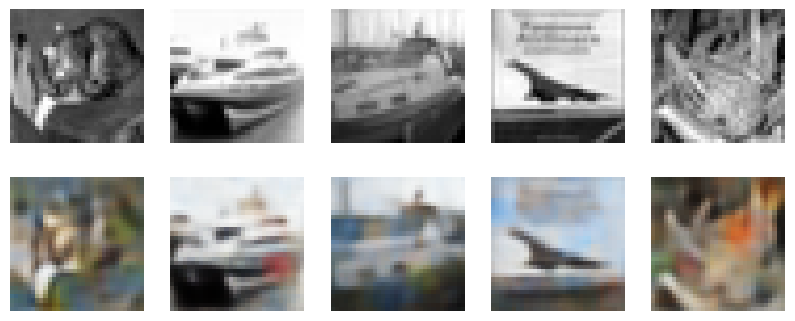

In [24]:
# create a visualization by sampling a batch of images from the test dataloader, converting to grayscale,
# and then colorizing them using the trained model

import matplotlib.pyplot as plt
import numpy as np

ae.eval()

image = next(iter(ae.test_dataloader()))[0]

# visualize
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for i in range(5):
    axs[0, i].imshow(image[i].squeeze().numpy(), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(ae(image)[i].detach().cpu().permute(1, 2, 0).numpy())
    axs[1, i].axis('off')